# Aufgabe-D-Schilder

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Bearbeiter
**TINF19-IT2**  
Patrick Küsters (9815596)  
Nick Kramer (3122448)  
**TINF19-IT1**  
Sören Holzenkamp (8528927)

## VM zum Trainieren großer Modelle

- Nutzung des Clusters der DHBW
    - wichtige Links
    - VPN-Endpunkt: drogon.dhbw-mannheim.de
    - Anmeldeseite Cluster: https://cloud.4c.dhbw-mannheim.de/
1. Ping external IP (Floating IP)
    1. Not working? --> New Floating IP
    2. Working --> ssh ubuntu@141.72.191.72 -i privatekey.txt

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/D_schilder herunter
    * Die Daten sind geschützt. 
    * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen ml_2021 anmelden. 
    



## Readme der Daten

This archive contains the following structure:

There is one directory for each of the 43 classes (0000 - 00043).
Each directory contains the corresponding training images and one 
text file with annotations, eg. GT-00000.csv. 


**********************************************
Image format and naming  
**********************************************
The images are PPM images (RGB color). Files are numbered in two parts:

   XXXXX_YYYYY.ppm

The first part, XXXXX, represents the track number. All images of one class 
with identical track numbers originate from one single physical traffic sign.
The second part, YYYYY, is a running number within the track. The temporal order
of the images is preserved.


**********************************************
Annotation format
**********************************************

The annotations are stored in CSV format (field separator
is ";" (semicolon) ). The annotations contain meta information 
about the image and the class id.


In detail, the annotations provide the following fields:

Filename        - Image file the following information applies to
Width, Height   - Dimensions of the image
Roi.x1,Roi.y1,
Roi.x2,Roi.y2   - Location of the sign within the image
		  (Images contain a border around the actual sign
                  of 10 percent of the sign size, at least 5 pixel)
ClassId         - The class of the traffic sign


## Aufgabe

* die Daten 
    * enthalten mehr als 50000 Bilder von Verkehrsschilder auf deutschen Straßen
    * pro Klasse der Daten gibt es ein Verzeichnis
    * in jeder Klasse gibt eine CSV-Datei mit Annotationen der Bilder
        * Die Namen lauten GT-<ClassID>.csv
* die Bilder 
    * enthalten genau ein Verkehrszeichen, mit ca. 10% Rand um das Verkehrszeichen
    * sind im PPM Format gespeichert
    * die Größen der Bilder variieren von 15x15 Pixel bis zu 250x250 Pixel
        * die Bilder müssen aber nicht quadratisch sein
    * In den Annotationen ist auch die Bounding Box hinterlegt
* die Annotations-Datei hat den folgenden Werte
    * Dateiname, Width, Height, BB.x1, BB.y1, BB.x2, BB.y2, ClassId
        * BB steht für BoundingBox

Erstellen Sie ein tiefes neuronales Netz, dass Schilder in Bildern erkennt und die Position des erkannten Schilds als Bounding Box ausgibt! Die Lösung soll auch mehrere Schilder in einem Bild erkennen können! 


# Lösung

Implementierung und Dokumentation

## Dictionary für alle Klassen im Datensatz

Quelle für die meisten Bezeichnungen: https://www.adac.de/verkehr/recht/verkehrszeichen/

In [1]:
classes = { 0:'Geschwindigkeitsbegrenzung (20km/h)',
            1:'Geschwindigkeitsbegrenzung (30km/h)',      
            2:'Geschwindigkeitsbegrenzung (50km/h)',       
            3:'Geschwindigkeitsbegrenzung (60km/h)',      
            4:'Geschwindigkeitsbegrenzung (70km/h)',    
            5:'Geschwindigkeitsbegrenzung (80km/h)',      
            6:'Ende der Geschwindigkeitsbegrenzung (80km/h)',     
            7:'Geschwindigkeitsbegrenzung (100km/h)',    
            8:'Geschwindigkeitsbegrenzung (120km/h)',     
            9:'Überholverbot',   
           10:'Überholverbot >3.5t',     
           11:'Vorfahrt nächste Kreuzung',     
           12:'Vorfahrtsstraße',    
           13:'Vorfahrt gewähren',     
           14:'Stop',       
           15:'Verbot für Fahrzeuge aller Art',       
           16:'Verbot für Fahrzeuge >3.5t',       
           17:'Verbot der Einfahrt',       
           18:'Gefahrenstelle',     
           19:'Kurve (links)',      
           20:'Kurve (rechts)',   
           21:'Doppelkurve',      
           22:'Unebene Fahrbahn',     
           23:'Schleuder-/Rutschgefahr',       
           24:'Einseitig (rechts) verengte Fahrbahn',  
           25:'Arbeitsstelle',    
           26:'Lichtzeichenanlage', # zu deutsch: Ampel      
           27:'Fußgänger',     
           28:'Kinder',     
           29:'Radfahrer',       
           30:'Schnee-/Eisglätte',
           31:'Wildwechsel',      
           32:'Ende sämtlicher Geschw-begr./Überholverb.',      
           33:'Vorgeschriebene Fahrtrichtung rechts',     
           34:'Vorgeschriebene Fahrtrichtung links',       
           35:'Vorgeschriebene Fahrtrichtung gerade',      
           36:'Vorgeschriebene Fahrtrichtung gerade/rechts',      
           37:'Vorgeschriebene Fahrtrichtung gerade/links',      
           38:'Vorgeschriebene Vorbeifahrt rechts vorbei',     
           39:'Vorgeschriebene Vorbeifahrt links vorbei',      
           40:'Kreisverkehr',     
           41:'Ende Überholverbot',      
           42:'Ende Überholverbot >3.5t' 
          }

## Imports
Lokal entwickelte Skripte und Module

In [2]:
import sys
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from reader import Reader
from display_data import ImageDisplayer
import collage

Externe Bibliotheken

In [4]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from skimage import transform
from sklearn.model_selection import train_test_split

## Einlesen der Daten
Der Datensatz besteht aus 43 Ordnern, welche je eine Klasse abbilden.  
- Beispiel: In Ordner 0 liegen ausschließlich Bilder von Tempo 20 Schildern ab  

### Reader
Reader() stellt eine selbst entwickelte Klasse dar. <a href="./src/reader.py">Sie ist hier zu finden</a>.<br>
Diese iteriert durch alle Ordner und liest die Annotation-Files ein. Diese Informationen werden in einem pandas DataFrame gespeichert.  

In [6]:
reader = Reader()
df = reader.read_data_to_df(folders=43, pre_path=r"./data/")
df

,Filename,Folder,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000_00000.ppm,./data/0/,29,30,5,6,24,25,0
1,00000_00001.ppm,./data/0/,30,30,5,5,25,25,0
2,00000_00002.ppm,./data/0/,30,30,5,5,25,25,0
3,00000_00003.ppm,./data/0/,31,31,5,5,26,26,0
4,00000_00004.ppm,./data/0/,30,32,5,6,25,26,0
...,...,...,...,...,...,...,...,...,...
39204,00007_00025.ppm,./data/42/,52,56,5,6,47,51,42
39205,00007_00026.ppm,./data/42/,56,58,5,5,51,53,42
39206,00007_00027.ppm,./data/42/,58,62,5,6,53,57,42
39207,00007_00028.ppm,./data/42/,63,69,5,7,58,63,42


### Beschreibung der Daten
Der Datensatz besteht aus 39209 Einträgen, welcher sich in 43 Klassen unterteilt.  
Jeder Eintrag stellt ein Bild dar, welches eine gewissen Breite und Höhe besitzt. **Die Bilder besitzen also nicht die gleiche Größe.**  
Zudem ist die "Bounding Box" durch die 4 Spalten beginnend mit Roi abgebildet. (X1, Y1) spannt mit (X2, Y2) ein Rechteck auf, in welchem sich das Verkehrszeichen befinden soll.

Zusätzlich wird der Pfad zu der einzelnen Bilder gespeichert. Der Grund hierfür ist die Nicht-Eindeutigkeit der Dateinamen über den eigenen Ordner hinaus.  
Dies geht auch aus dem Readme der Daten hervor (ein Dateiname besteht aus Track und Tracknummer).  

In [7]:
lookup_filename = "00000_00000.ppm"
print("Vorkommnisse von " + lookup_filename + ":")
print(len(df.index[df["Filename"] == lookup_filename]))

print()

lookup_folder_with_filename = r"./data/0/00000_00000.ppm"
print("Vorkommnisse von " + lookup_folder_with_filename + ":")
print(len(df.index[df["Folder"] + df["Filename"] == lookup_folder_with_filename]))

Vorkommnisse von 00000_00000.ppm:
43

Vorkommnisse von ./data/0/00000_00000.ppm:
1


In [8]:
#ImageDisplayer(df, 100, 105)

## Plots zur Veranschaulichung des Datensatzes
### Ausgewogenheit

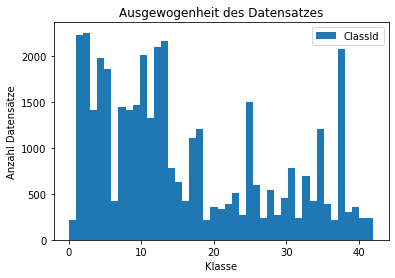

In [9]:
df.plot(y="ClassId", kind="hist", bins=len(set(df["ClassId"])))
plt.title("Ausgewogenheit des Datensatzes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Klasse")
plt.show()

Der Datensatz ist sehr **unausgewogen**. Einige Klassen verfügen über sehr viele Datensätze, während andere nur sehr wenige besitzen.
Das neuronale Netz könnte zu sehr auf einige Klassen trainiert werden, daher sollte eine Angleichung der Menge der Datensätze pro Klasse stattfinden.  
Am Beispiel der Klassen 0 und 1:

In [10]:
print("Anzahl Datensätze 20er Schild:", len(df[df["ClassId"] == 0]))
print("Anzahl Datensätze 30er Schild:", len(df[df["ClassId"] == 1]))
print("Faktor:", round(len(df[df["ClassId"] == 1])/len(df[df["ClassId"] == 0]), 2))

Anzahl Datensätze 20er Schild: 210
Anzahl Datensätze 30er Schild: 2220
Faktor: 10.57


### Bildbreite und Höhe

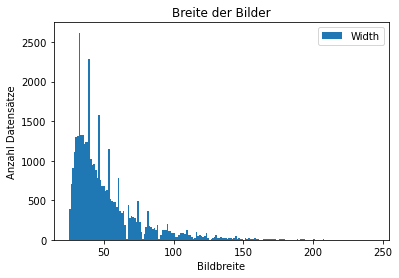

In [11]:
df.plot(y="Width", kind="hist", bins=len(set(df["Width"])))
plt.title("Breite der Bilder")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Bildbreite")
plt.show()

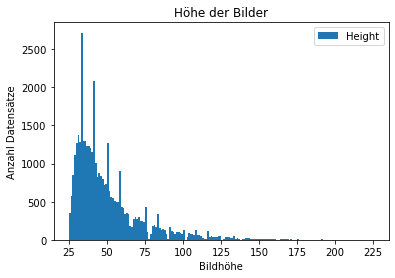

In [12]:
df.plot(y="Height", kind="hist", bins=len(set(df["Height"])))
plt.title("Höhe der Bilder")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Bildhöhe")
plt.show()

Die Bilder verfügen über unterschiedliche Höhen und Breiten. Der Großteil der Bilder ist bis zu 50 Pixeln breit und bis zu ca. 60 Pixeln hoch.  
Auffällig sind einige "Spikes" in den Grafiken, was bedeutet, dass viele Bilder die gewisse Breite oder Höhe besitzen.  

### Bildfläche

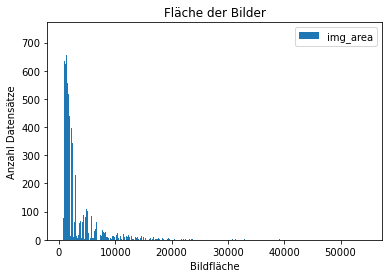

In [13]:
df["img_area"] = df["Width"]*df["Height"]
df.plot(y="img_area", kind="hist", bins=len(set(df["img_area"])))
plt.title("Fläche der Bilder")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Bildfläche")
plt.show()

Folgend aus den Höhen und Breiten sind die Bildflächen verschieden.  
Auch hier befinden sich die meisten Einträge im unteren Spektrum der x-Achse.

### Bounding-Box Länge, Höhe und Fläche

In [14]:
df["x_box_len"] = df["Roi.X2"] - df["Roi.X1"]
df["y_box_len"] = df["Roi.Y2"] - df["Roi.Y1"]
df["box_area"] = df["x_box_len"]*df["y_box_len"]

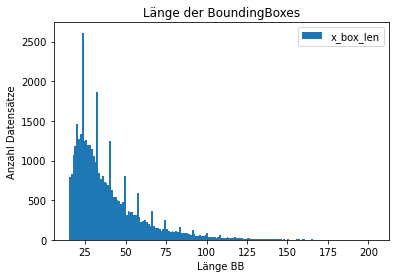

In [15]:
df.plot(y="x_box_len", kind="hist", bins=len(set(df["x_box_len"])))
plt.title("Länge der BoundingBoxes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Länge BB")
plt.show()

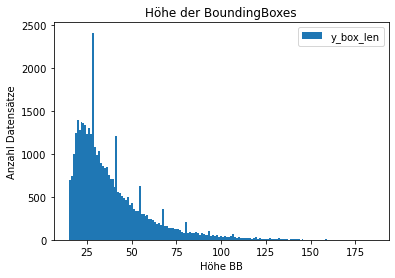

In [16]:
df.plot(y="y_box_len", kind="hist", bins=len(set(df["y_box_len"])))
plt.title("Höhe der BoundingBoxes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Höhe BB")
plt.show()

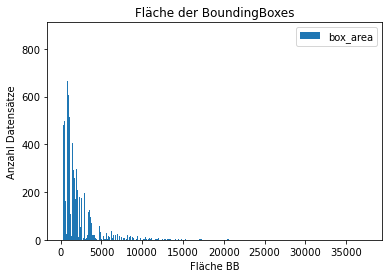

In [17]:
df.plot(y="box_area", kind="hist", bins=len(set(df["box_area"])))
plt.title("Fläche der BoundingBoxes")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Fläche BB")
plt.show()

Die Bounding-Boxes verhalten sich wie die Bilder selbst. Auch hier sind einige "Spikes" bei der Höhe und Breite zu erkennen.  
Die meisten Bounding-Boxes sind bis zu ca. 40 Pixel hoch und breit.  
Dies kann für die spätere Transformation der Größe genutzt werden, da die zugeschnitten Bilder später alle die gleiche Maß besitzen müssen.

## Bildklassifizierung
### Vorbereitung

In [18]:
from skimage import exposure
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

#### Darstellung und Überblick
Um ein Gefühl für die Daten zu bekommen, wird eine Collage erstellt, die jedes 500. Bild darstellt.

In [19]:
collage.create_collage(r"./images/collage_cropped_images2.png", df)

Darstellungen ohne weitere Nachbearbeitung (nur Zuschnitt auf Bounding Box):

<img src="./images/collage_cropped_images2.png">

Es ist auffällig, dass die Qualität der Bilder stark unterschiedlich ist:
- Einige Bilder sind extrem dunkel und besitzen einen geringen Kontrast. 
- Durch das Skalieren der Bilder unterscheidet sich die Auflösung stark.

Teilweise sind Schilder selbst für ein menschliches Auge nicht eindeutig identifizierbar.  
**************
Es sind folgende Gemeinsamkeiten festzustellen:
- Der Bildwinkel ist immer gleich
- Die Schilder sind vollständig abgebildet und besitzen keine "Störungen" (Überdeckungen, Verunreinigungen, ...)

Dies lässt die Frage offen, ob ein späteres Modell Bilder aus dem "echten" Leben erkennen kann.

Im Zuge der Recherche für die Datenvorbereitung fiel ein <a href="https://medium.com/@thomastracey/recognizing-traffic-signs-with-cnns-23a4ac66f7a7">Paper</a> auf, welches ein Verfahren namens "CLAHE" nutzte um einen größeren Kontrast herzustellen.<br>
Beim späteren Trainieren neuronaler Netze kann betrachtet werden, ob dies einen signifikanten Unterschied bei der Leistung des Modells mit sich bringt.

Um die Auswirkungen des Verfahrens zu testen, wird eine Collage der angepassten Bilder erstellt. 

In [20]:
collage.create_preprocessed_collage(r"./images/collage_preprocessed_images2.png", df)

Bilder mit Nachbearbeitung (höherer Kontrast):

<img src="./images/collage_preprocessed_images2.png">

### Daten einlesen
Um das neuronale Netz trainieren zu können, werden die Eingabedaten und Labels benötigt.  
Auf Grund der vorherigen Schritte ist es möglich, über das erstellte DataFrame zu iterieren und jedes einzelne Bild auszulesen und zu bearbeiten. Im Anschluss daran wird es einer List hinzugefügt, was am Ende des Prozesses alle Bilder beinhaltet.   
Das **data**-Array beinhaltet alle Bilddaten
Das **labels**-Array beinhaltet die Klassenzugehörigkeiten  

#### read_preprocess_img
Die Bilder werden mit OpenCV eingelesen und auf die Maße der Bounding Box zugeschnitten. Im Anschluss folgt eine Anpassung der Bildgröße, damit alle Images eine einheitliche Größe besitzen.   
Als nächster Schritt folgt eine Histogramm-Equalization. Dies hat als Ziel, das Histogramm der Bilder jeweils so anzupassen, dass alle Grauwerte möglichst gleichverteilt sind. Bei der Histogramm Equalization berechnen sich die Grauwerte der Pixel wie folgt: 

$y=f(p)= \frac{L-1}{N}\int_{-\infty}^{p} h_{i}(p) \,dp$

Mit: x - alter Grauwert; N - Anzahl Pixel; L - Anzahl möglicher Grauwerte

In unserem Fall stützen wir uns auf die von skimage implementierte Funktion ```equalize_adapthist```, was ein Problem der einfachen Histogramm Equalization löst, bei welchem Informationsverlust in den Bildern auftritt. Es nutzt die Contrast Limited Adaptive Histogram Equalization (CLAHE). Eine Visualisierung der normalisierten Bilder kann in der weiter oben dargestellten Collage betrachtet werden.


Im Anschluss werden die Arrays in numpy-Arrays umgewandelt.

In [21]:
data = []
labels = []

for index, row in df.iterrows(): 
    if index>0 and index%5000 == 0:
        print("Iterated through", index, "images")
    elif index+1 == len(df):
        print("Iterated through all images")
        
    x = row["Roi.X1"]
    y = row["Roi.Y1"]
    h = row["Roi.Y2"]-row["Roi.Y1"]
    w = row["Roi.X2"]-row["Roi.X1"]
    
    data.append(Reader.read_preprocess_img(Reader, row["Folder"]+row["Filename"], (32,32), x, y, h, w))
    labels.append(int(row["ClassId"]))

data = np.array(data)
labels = np.array(labels)

Iterated through 5000 images
Iterated through 10000 images
Iterated through 15000 images
Iterated through 20000 images
Iterated through 25000 images
Iterated through 30000 images
Iterated through 35000 images
Iterated through all images


### Daten-Augmentierung
Bei der Augmentierung sollen die Daten transformiert werden.  
Dabei werden die herausgestellten Herausforderungen und Probleme des Datensatzes in Angriff genommen. Identifizierte Probleme:
1. Unausgewogenheit des Datensatzes
2. Immer gleiche Blickwinkel und keine "Störungen" (nichts verdeckt...)

Für Punkt eins ist eine Lösung, mehr Bilder aus dem Datensatz zu generieren und dabei die Klassen gleich zu verteilen.

In [22]:
tmp_labels = labels
tmp_data = data

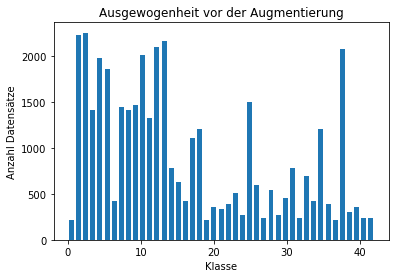

In [23]:
plt.hist(labels, bins=len(set(labels)), rwidth=0.7)
plt.title("Ausgewogenheit vor der Augmentierung")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Klasse")
plt.show()

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

datagen = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    channel_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

C:\Users\NickK\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [25]:
images_per_class = 6000
data_aug = np.empty((0, 32, 32, 3))
labels_aug = np.empty(0, dtype='int32')

for i in tqdm(range(len(set(labels)))):
    # Get images and labels for each class
    index = [labels==i]
    i_data = data[tuple(index)]
    i_labels = labels[tuple(index)]
    
    i_data_aug = np.copy(i_data)
    i_labels_aug = np.copy(i_labels)
    
    # append augmented data to existing class-data
    for X, y in datagen.flow(i_data, i_labels, batch_size=len(i_labels), seed=3*i+52):
        i_data_aug = np.append(i_data_aug, X, axis=0)
        i_labels_aug = np.append(i_labels_aug, y, axis=0)
        
        if len(i_labels_aug) >= images_per_class:
            break
    
    # append data to result arrays
    # limit to appending images to maximum images (take rows up to rownumber specified)
    data_aug = np.append(data_aug, i_data_aug[:images_per_class], axis=0)
    labels_aug = np.append(labels_aug, i_labels_aug[:images_per_class], axis=0)


  0%|                                                                                           | 0/43 [00:00<?, ?it/s]C:\Users\NickK\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\NickK\anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [04:21<00:00,  6.07s/it]


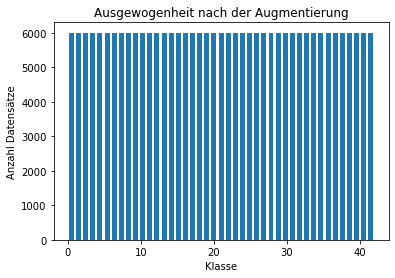

In [26]:
plt.hist(labels_aug, bins=len(set(labels_aug)), rwidth=0.7)
plt.title("Ausgewogenheit nach der Augmentierung")
plt.ylabel("Anzahl Datensätze")
plt.xlabel("Klasse")
plt.show()

In [27]:
print("Pre-defined data shape:",data.shape)
print("Data shape after augmentation:",data_aug.shape)
print("--> Anzahl Datensätze:", len(data_aug))

Pre-defined data shape: (39209, 32, 32, 3)
Data shape after augmentation: (258000, 32, 32, 3)
--> Anzahl Datensätze: 258000


### Aufteilung
Aufteilung in Trainings-/Test- und Validierungsdaten  

**Trainingsdaten**  
Dienen zum Training des neuronalen Netzes. Mit 75% des gesamten Datensatzes wird hier der Großteil der Daten genutzt.

**Validierungsdaten**  
Dienen zum Testen des neuronalen Netzes während des Trainings. Hierfür werden 17.5% der Daten vorgehalten.

**Testdaten**  
Dienen zur Evaluation des neuronalen Netzes nach dem Training. Validierungsadaten eignen sich hier nicht, da das neuronale Netz diese Daten bereits "gesehen" hat. Es dient als weitere Instanz, Über und Unteranpassung zu erkennen. Der Testdatensatz umfasst 17.5% des Datensatzes.

In [28]:
# train and test (0.75, 0.25)
X_train, X_test, y_train, y_test = train_test_split(data_aug, labels_aug, test_size=0.25, random_state=1234)

# split test in val and test (0.5, 0.5 of test-data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1234)

In [29]:
# Scale to [0,1]
X_train = X_train.astype("float32")/255.0
X_test = X_test.astype("float32")/255.0
X_val = X_val.astype("float32")/255.0

# One-Hot Encoding (dont drop one column)
print(y_train.shape)
y_train = to_categorical(y_train, 43)
print(y_train.shape)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

(193500,)
(193500, 43)


### CNN / Klassifizierung
Aufbau des CNN

In [30]:
class TrafficSignNetwork:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # CONV => RELU => BN => POOL
        model.add(Conv2D(8, (5, 5), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # second set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        # return the constructed network architecture
        return model
    
    @staticmethod
    def build_tuner(hp):
        width = 32
        height = 32
        depth = 3
        classes = 43
        model = Sequential()
        inputShape = (height, width, depth)
        
        for i in range(hp.Int('conv_blocks', 2, 5, default=3)):
            filters = hp.Int('filters_' + str(i), 8, 64, step=8)
            # CONV => RELU => BN => POOL
            model.add(Conv2D(filters, (5, 5), padding="same",
                input_shape=inputShape))
            model.add(Activation("relu"))
            model.add(BatchNormalization())
            
            pool_choice = hp.Choice('pooling_' + str(i), ['avg', 'max', ''])
            if pool_choice == 'max':
                model.add(MaxPooling2D(pool_size=(2, 2)))
            elif pool_choice == 'avg':
                model.add(AvgPool2D(pool_size=(2, 2)))
        
        for i in range(hp.Int('fully_connected', 1, 3, default=2)):
            # first set of FC => RELU layers
            hp_units = hp.Int('units_' + str(i), min_value=32, max_value=512, step=32)
            model.add(Flatten())
            model.add(Dense(hp_units))
            model.add(Activation("relu"))
            model.add(BatchNormalization())
            model.add(Dropout(0.5))
                
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        loss = hp.Choice('loss_function', ['SCC', 'CC'])
        if loss == 'SCC':
            chosen_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        else:
            chosen_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=chosen_loss,
                metrics=['accuracy'])
        
        # return the constructed network architecture
        return model

In [31]:
import keras_tuner as kt

tuner = kt.Hyperband(
    TrafficSignNetwork.build_tuner,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=1,
    seed=1234,
    project_name='kt_signdetection_network'
    )

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json


In [33]:
tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=30,
             batch_size=128,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)])


Search: Running Trial #3

Hyperparameter    |Value             |Best Value So Far 
conv_blocks       |3                 |?                 
filters_0         |8                 |?                 
pooling_0         |avg               |?                 
filters_1         |48                |?                 
pooling_1         |                  |?                 
filters_2         |16                |?                 
pooling_2         |max               |?                 
fully_connected   |2                 |?                 
units_0           |256               |?                 
units_1           |256               |?                 
learning_rate     |0.001             |?                 
loss_function     |CC                |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |3                 |?                 
tuner/round       |0                 |?                 

Epo

KeyboardInterrupt: 

In [ ]:
NUM_EPOCHS = 20
INIT_LR = 1e-3
BS = 128

In [ ]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNetwork.build(width=32, height=32, depth=3, classes=43)
# Umsetzung der Empfehlung, die logit-Variante vorzuziehen
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=opt, metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
H = model.fit(X_train, y_train,
              validation_data=(X_val, y_val),
              epochs = NUM_EPOCHS,
              batch_size = BS
            )
model.save(r"./models/aug_model_40ep.h5")

In [ ]:
hist = H.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
preds = model.predict(X_test)
preds = tf.argmax(preds, axis=1)
preds

### Diskussion der Ergebnisse
- Wenige Layer und hohe Anzahl an Epochen: 
    - Einbrechen der validation_accuracy nach 15-20 Epochen (Overfitting)
- a

In [ ]:
print(classes[preds[0].numpy()])
cv2.imshow("Image",X_test[0]*255)
k = cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
wrong_preds = preds.numpy() !=  tf.argmax(y_test, axis=1).numpy()
wrong_preds_index = np.where(wrong_preds == True)
print("Falsche Vorhersagen:", len(wrong_preds_index[0]), "von:", len(preds.numpy()))

In [ ]:
#for i in wrong_predictions_index[0]:
 #   print(classes[real[i].numpy()])
  #  cv2.imshow("Image",X_test[i]*255)
   # k = cv2.waitKey(0)
    #cv2.destroyAllWindows()

In [ ]:
X_train[0].shape
type(X_train)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(r"./models/first_model.h5")

In [ ]:
data2 = []
#--------------
image = cv2.imread(r"./images/Baustell.png")
image = transform.resize(image, (32, 32))   #cv2.resize??
image = exposure.equalize_adapthist(image, clip_limit=0.1)
#------------- replace by implementation in reader-class 
data2.append(image)
data2 = np.asarray(data2)
data2 = data2.astype("float32")/255.0
preds = model.predict(data2)
print(preds)
print(sum(preds[0]))
preds = tf.argmax(preds, axis=1)
print("Prediction: " + classes[preds[0].numpy()])

In [ ]:
model.save(r"./models/first_model.h5")